In [144]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
url = 'https://docs.google.com/spreadsheets/d/1HcdISgCl3s4RpWkJa8m-G1JjfKzd8qf2WY2Xcw32D7U/pub?gid=1371955398&single=true&output=csv'

In [399]:
import pandas
import re
from enum import Enum

class Character(Enum):
   
    def __ge__(self, other):
        if self.__class__ is other.__class__:
            return self.value >= other.value
        return NotImplemented
    def __gt__(self, other):
        if self.__class__ is other.__class__:
            return self.value > other.value
        return NotImplemented
    def __le__(self, other):
        if self.__class__ is other.__class__:
            return self.value <= other.value
        return NotImplemented
    def __lt__(self, other):
        if self.__class__ is other.__class__:
            return self.value < other.value
        return NotImplemented

    Gwen = 'gwen'
    Setsuki = 'setsuki'
    Troq = 'troq'
    DeGrey = 'degrey'
    Zane = 'zane'
    Midori = 'midori'
    Grave = 'grave'
    Geiger = 'geiger'
    Menelker = 'menelker'
    Lum = 'lum'
    Quince = 'quince'
    Rook = 'rook'
    BBB = 'bbb'
    Onimaru = 'onimaru'
    Vendetta = 'vendetta'
    Jaina = 'jaina'
    Argagarg = 'argagarg'
    Valerie = 'valerie'
    Persephone = 'persephone'
    Gloria = 'gloria'
    
for char in Character:
    locals()[char.name] = char
    
historical_record = pandas.read_csv(url)
historical_record.columns = [re.sub('\W+', '_', col.lower()).strip('_') for col in historical_record.columns]

historical_record = historical_record[
    ~historical_record.character_1.isin(['Squall', 'Kefka', 'Ultimicia']) &
    ~historical_record.character_2.isin(['Squall', 'Kefka', 'Ultimicia'])
]

historical_record.character_2.replace(to_replace=['variable'], value=['Gloria'], inplace=True)

names = pandas.DataFrame({'name': historical_record.player_1.append(historical_record.player_2)})
names['lower'] = names.apply(lambda r: r['name'].lower(), axis=1)
name_map = names.groupby('lower').first()

historical_record['match_date'] = pandas.to_datetime(historical_record.match_date, infer_datetime_format=True)
historical_record.format_restricted.replace(to_replace=['.', 'Restricted'], value=[False, True], inplace=True)
historical_record.format_team.replace(to_replace=['.', 'Team'], value=[False, True], inplace=True)
historical_record.char_select_random.replace(to_replace=['.', 'Random'], value=[False, True], inplace=True)
historical_record.char_select_locked.replace(to_replace=['.', 'Locked'], value=[False, True], inplace=True)
historical_record.set_length_non_ft3_ft4.replace(to_replace=['.', 'non-FT3/FT4'], value=[False, True], inplace=True)
historical_record.set_win_1 = historical_record.set_win_1.fillna(0)
historical_record.set_win_2 = historical_record.set_win_2.fillna(0)
historical_record.wins_1 = historical_record.wins_1.fillna(0)
historical_record.wins_2 = historical_record.wins_2.fillna(0)
historical_record.character_1 = historical_record.character_1.apply(lambda n: Character(n.lower()))
historical_record.character_2 = historical_record.character_2.apply(lambda n: Character(n.lower()))
historical_record.player_1 = historical_record.player_1.apply(lambda n: name_map.loc[n.lower()])
historical_record.player_2 = historical_record.player_2.apply(lambda n: name_map.loc[n.lower()])


In [402]:
from scipy.stats import norm
import math

def ci_bounds(pos, n, confidence):
    if n == 0:
        return (0, 0)
    z = norm.ppf(1-(1-confidence)/2)
    phat = 1.0*pos/n
    return (
        (phat + z*z/(2*n) - z * math.sqrt((phat*(1-phat)+z*z/(4*n))/n))/(1+z*z/n),
        (phat + z*z/(2*n) + z * math.sqrt((phat*(1-phat)+z*z/(4*n))/n))/(1+z*z/n),
    )


In [403]:
def pct_bounds(groups):
    wins = groups['wins', 'losses'].sum()

    wins['lower'] = wins.apply(lambda r: ci_bounds(r.wins, (r.wins + r.losses), 0.75)[0], axis=1)
    wins['upper'] = wins.apply(lambda r: ci_bounds(r.wins, (r.wins + r.losses), 0.75)[1], axis=1)
    
    return wins

In [404]:
matches = historical_record[[
    'player_1', 'character_1', 'wins_1',
    'wins_2', 'character_2', 'player_2'
]].append(
    historical_record[[
        'player_1', 'character_1', 'wins_1',
        'wins_2', 'character_2', 'player_2',
    ]].rename(columns={
        'player_1': 'player_2',
        'character_1': 'character_2',
        'wins_1': 'wins_2',
        'player_2': 'player_1',
        'character_2': 'character_1',
        'wins_2': 'wins_1',
    })
).rename(columns={
    'player_1': 'player',
    'character_1': 'as_character',
    'wins_1': 'wins',
    'wins_2': 'losses',
    'character_2': 'against_character',
    'player_2': 'against_player',
})


In [405]:
player_ratings = pct_bounds(matches.groupby(['player', 'as_character']))

In [406]:
matches['played'] = matches.wins + matches.losses

In [485]:
play_counts = matches.groupby(['player', 'as_character']).played.sum()
character_cutoffs = player_ratings[(play_counts > 30)].groupby('as_character').lower.quantile(.8)
player_ratings['frequent_player'] = play_counts > 30
win_rates = player_ratings.reset_index()
win_rates['high_win_rate'] = win_rates.apply(lambda r: r.lower > character_cutoffs[r.as_character], axis=1)
player_ratings.high_win_rate = win_rates.set_index(['player', 'as_character']).high_win_rate
specialists = player_ratings[player_ratings.frequent_player & player_ratings.high_win_rate]

In [486]:
specialists

wins  losses     lower     upper  \
player             as_character                                              
BD_Corro           Character.Setsuki      78.0    50.0  0.558890  0.657622   
Bob199             Character.Argagarg     63.0    45.0  0.528074  0.636575   
                   Character.DeGrey       51.0    33.0  0.544637  0.666326   
                   Character.Valerie      23.0    14.0  0.527204  0.707641   
                   Character.Zane         99.0    60.0  0.577580  0.665679   
Bomber678          Character.Geiger       25.0    12.0  0.582411  0.756808   
                   Character.Rook         23.0    14.0  0.527204  0.707641   
                   Character.Zane         53.0    30.0  0.576157  0.696602   
CKR                Character.Zane        125.0    81.0  0.567084  0.645145   
Caralad            Character.Onimaru      30.0    16.0  0.568161  0.727677   
                   Character.Rook         37.0    25.0  0.523810  0.665694   
                   Character.Troq         63.0    35.0  0.585614  0.696294   
ClanNatioy         Character.Grave        50.0    25.0  0.601638  0.725916   
CloudCuckooCountry Character.Geiger       73.0    40.0  0.592851  0.695804   
EricF              Character.Persephone   48.0    40.0  0.484171  0.605391   
FenixOfTheAshes    Character.Onimaru      41.0    22.0  0.579244  0.716138   
Fivec              Character.Setsuki     361.0   222.0  0.595831  0.642051   
Fluffiness         Character.Persephone   82.0    58.0  0.537238  0.632585   
Fusxfaranto        Character.Gwen         79.0    61.0  0.515699  0.611669   
Jengajam           Character.BBB          22.0    11.0  0.567457  0.753025   
                   Character.DeGrey       30.0    18.0  0.542278  0.701015   
Kirandio           Character.Jaina        55.0    46.0  0.487341  0.600616   
LK4O4              Character.Gloria      158.0   134.0  0.507440  0.574381   
Legion             Character.Grave        76.0    54.0  0.534288  0.633238   
                   Character.Valerie      33.0    17.0  0.579698  0.732051   
Leontes            Character.Menelker     36.0    24.0  0.525845  0.669840   
                   Character.Midori      242.0   185.0  0.538995  0.594082   
                   Character.Setsuki      24.0    12.0  0.571798  0.749717   
MadKing            Character.Quince      101.0    70.0  0.546852  0.633042   
Mallorean_Thug     Character.DeGrey      174.0   138.0  0.525171  0.589727   
...                                        ...     ...       ...       ...   
Raziek             Character.Valerie      26.0    17.0  0.516988  0.686065   
                   Character.Zane        267.0   161.0  0.596553  0.650347   
Redless            Character.Menelker     28.0    21.0  0.489280  0.649821   
Ryker              Character.Grave        33.0    16.0  0.592727  0.745089   
Silmerion          Character.Quince       58.0    47.0  0.496251  0.607207   
SirHandsome        Character.Gloria       33.0    23.0  0.512449  0.662001   
Thelo              Character.BBB          60.0    34.0  0.579732  0.693024   
Zqxx               Character.Argagarg    104.0    72.0  0.547752  0.632709   
cpat               Character.Setsuki      48.0    27.0  0.574322  0.700823   
                   Character.Zane         68.0    27.0  0.659876  0.765774   
deluks917          Character.Geiger       62.0    34.0  0.588047  0.699654   
                   Character.Lum          45.0    19.0  0.633852  0.764168   
                   Character.Troq         80.0    38.0  0.626746  0.725238   
drnd               Character.Gwen         20.0    13.0  0.505943  0.698000   
                   Character.Vendetta     49.0    31.0  0.548497  0.672842   
enomus             Character.Vendetta     79.0    51.0  0.557582  0.655632   
flagrantangles     Character.Quince      138.0   119.0  0.501087  0.572465   
mastrblastr        Character.Argagarg     32.0    15.0  0.598601  0.753196   
                   Character.DeGrey       46.0    32.0  0.524697

In [487]:
specialist_chars = set(specialists.index.values)

In [488]:
matches['expert_game'] = matches.apply(lambda r: (r.player, r.as_character) in specialist_chars and (r.against_player, r.against_character) in specialist_chars, axis=1)

In [489]:
expert_mu_pcts = pct_bounds(matches[matches.expert_game].groupby(['as_character', 'against_character']))

In [490]:
expert_mu_pcts

wins  losses     lower     upper
as_character       against_character                                     
Character.Argagarg Character.BBB          0.0     1.0  0.000000  0.569578
                   Character.DeGrey       2.0     1.0  0.349905  0.881400
                   Character.Geiger       3.0     2.0  0.353987  0.804159
                   Character.Gloria       1.0     1.0  0.184489  0.815511
                   Character.Grave        5.0     5.0  0.329072  0.670928
                   Character.Gwen         0.0     2.0  0.000000  0.398189
                   Character.Lum          2.0     0.0  0.601811  1.000000
                   Character.Midori       2.0     2.0  0.250708  0.749292
                   Character.Onimaru      2.0     0.0  0.601811  1.000000
                   Character.Persephone   0.0     1.0  0.000000  0.569578
                   Character.Quince       1.0    10.0  0.030894  0.238782
                   Character.Rook         2.0     4.0  0.160812  0.566087
                   Character.Setsuki      1.0     4.0  0.069326  0.456239
                   Character.Troq         2.0     0.0  0.601811  1.000000
                   Character.Valerie      0.0     1.0  0.000000  0.569578
                   Character.Vendetta     1.0     6.0  0.049000  0.350277
                   Character.Zane         0.0     2.0  0.000000  0.398189
Character.BBB      Character.Argagarg     1.0     0.0  0.430422  1.000000
                   Character.Grave        0.0     2.0  0.000000  0.398189
                   Character.Gwen         1.0     3.0  0.087486  0.536807
                   Character.Midori       4.0     1.0  0.543761  0.930674
                   Character.Quince       8.0     2.0  0.623775  0.906106
                   Character.Setsuki      0.0     1.0  0.000000  0.569578
                   Character.Troq         3.0     4.0  0.242280  0.637576
                   Character.Vendetta     0.0     1.0  0.000000  0.569578
                   Character.Zane         0.0     2.0  0.000000  0.398189
Character.DeGrey   Character.Argagarg     1.0     2.0  0.118600  0.650095
                   Character.Geiger       2.0     2.0  0.250708  0.749292
                   Character.Gloria       4.0     1.0  0.543761  0.930674
                   Character.Grave        5.0     1.0  0.603617  0.942585
...                                       ...     ...       ...       ...
Character.Vendetta Character.Lum          1.0     4.0  0.069326  0.456239
                   Character.Menelker     1.0     0.0  0.430422  1.000000
                   Character.Midori       1.0     5.0  0.057415  0.396383
                   Character.Onimaru      1.0     0.0  0.430422  1.000000
                   Character.Persephone   5.0     3.0  0.424007  0.790509
                   Character.Quince       7.0     3.0  0.518235  0.835019
                   Character.Rook         5.0     4.0  0.370385  0.726484
                   Character.Setsuki      5.0     5.0  0.329072  0.670928
                   Character.Troq         1.0     1.0  0.184489  0.815511
                   Character.Zane         6.0     9.0  0.268385  0.547828
Character.Zane     Character.Argagarg     2.0     0.0  0.601811  1.000000
                   Character.BBB          2.0     0.0  0.601811  1.000000
                   Character.DeGrey      13.0    10.0  0.445987  0.677351
                   Character.Geiger       3.0     3.0  0.287457  0.712543
                   Character.Gloria      25.0    13.0  0.565390  0.739772
                   Character.Grave        9.0    10.0  0.347977  0.602818
                   Character.Gwen         1.0     0.0  0.430422  1.000000
                   Character.Jaina        4.0     1.0  0.543761  0.930674
                   Character.Lum          0.0     1.0  0.000000  0.569578
                   Character.Menelker     6.0     1.0  0.649723  0.951000
                   Character.Midori      14.0    14.0  0.393783  0.606217
                   Character.Onimaru      2.0

In [491]:
expert_mu_pcts['range'] = expert_mu_pcts.apply(lambda r: "{}/{}".format(round(r.lower*100)/10, round(r.upper*100)/10), axis=1)

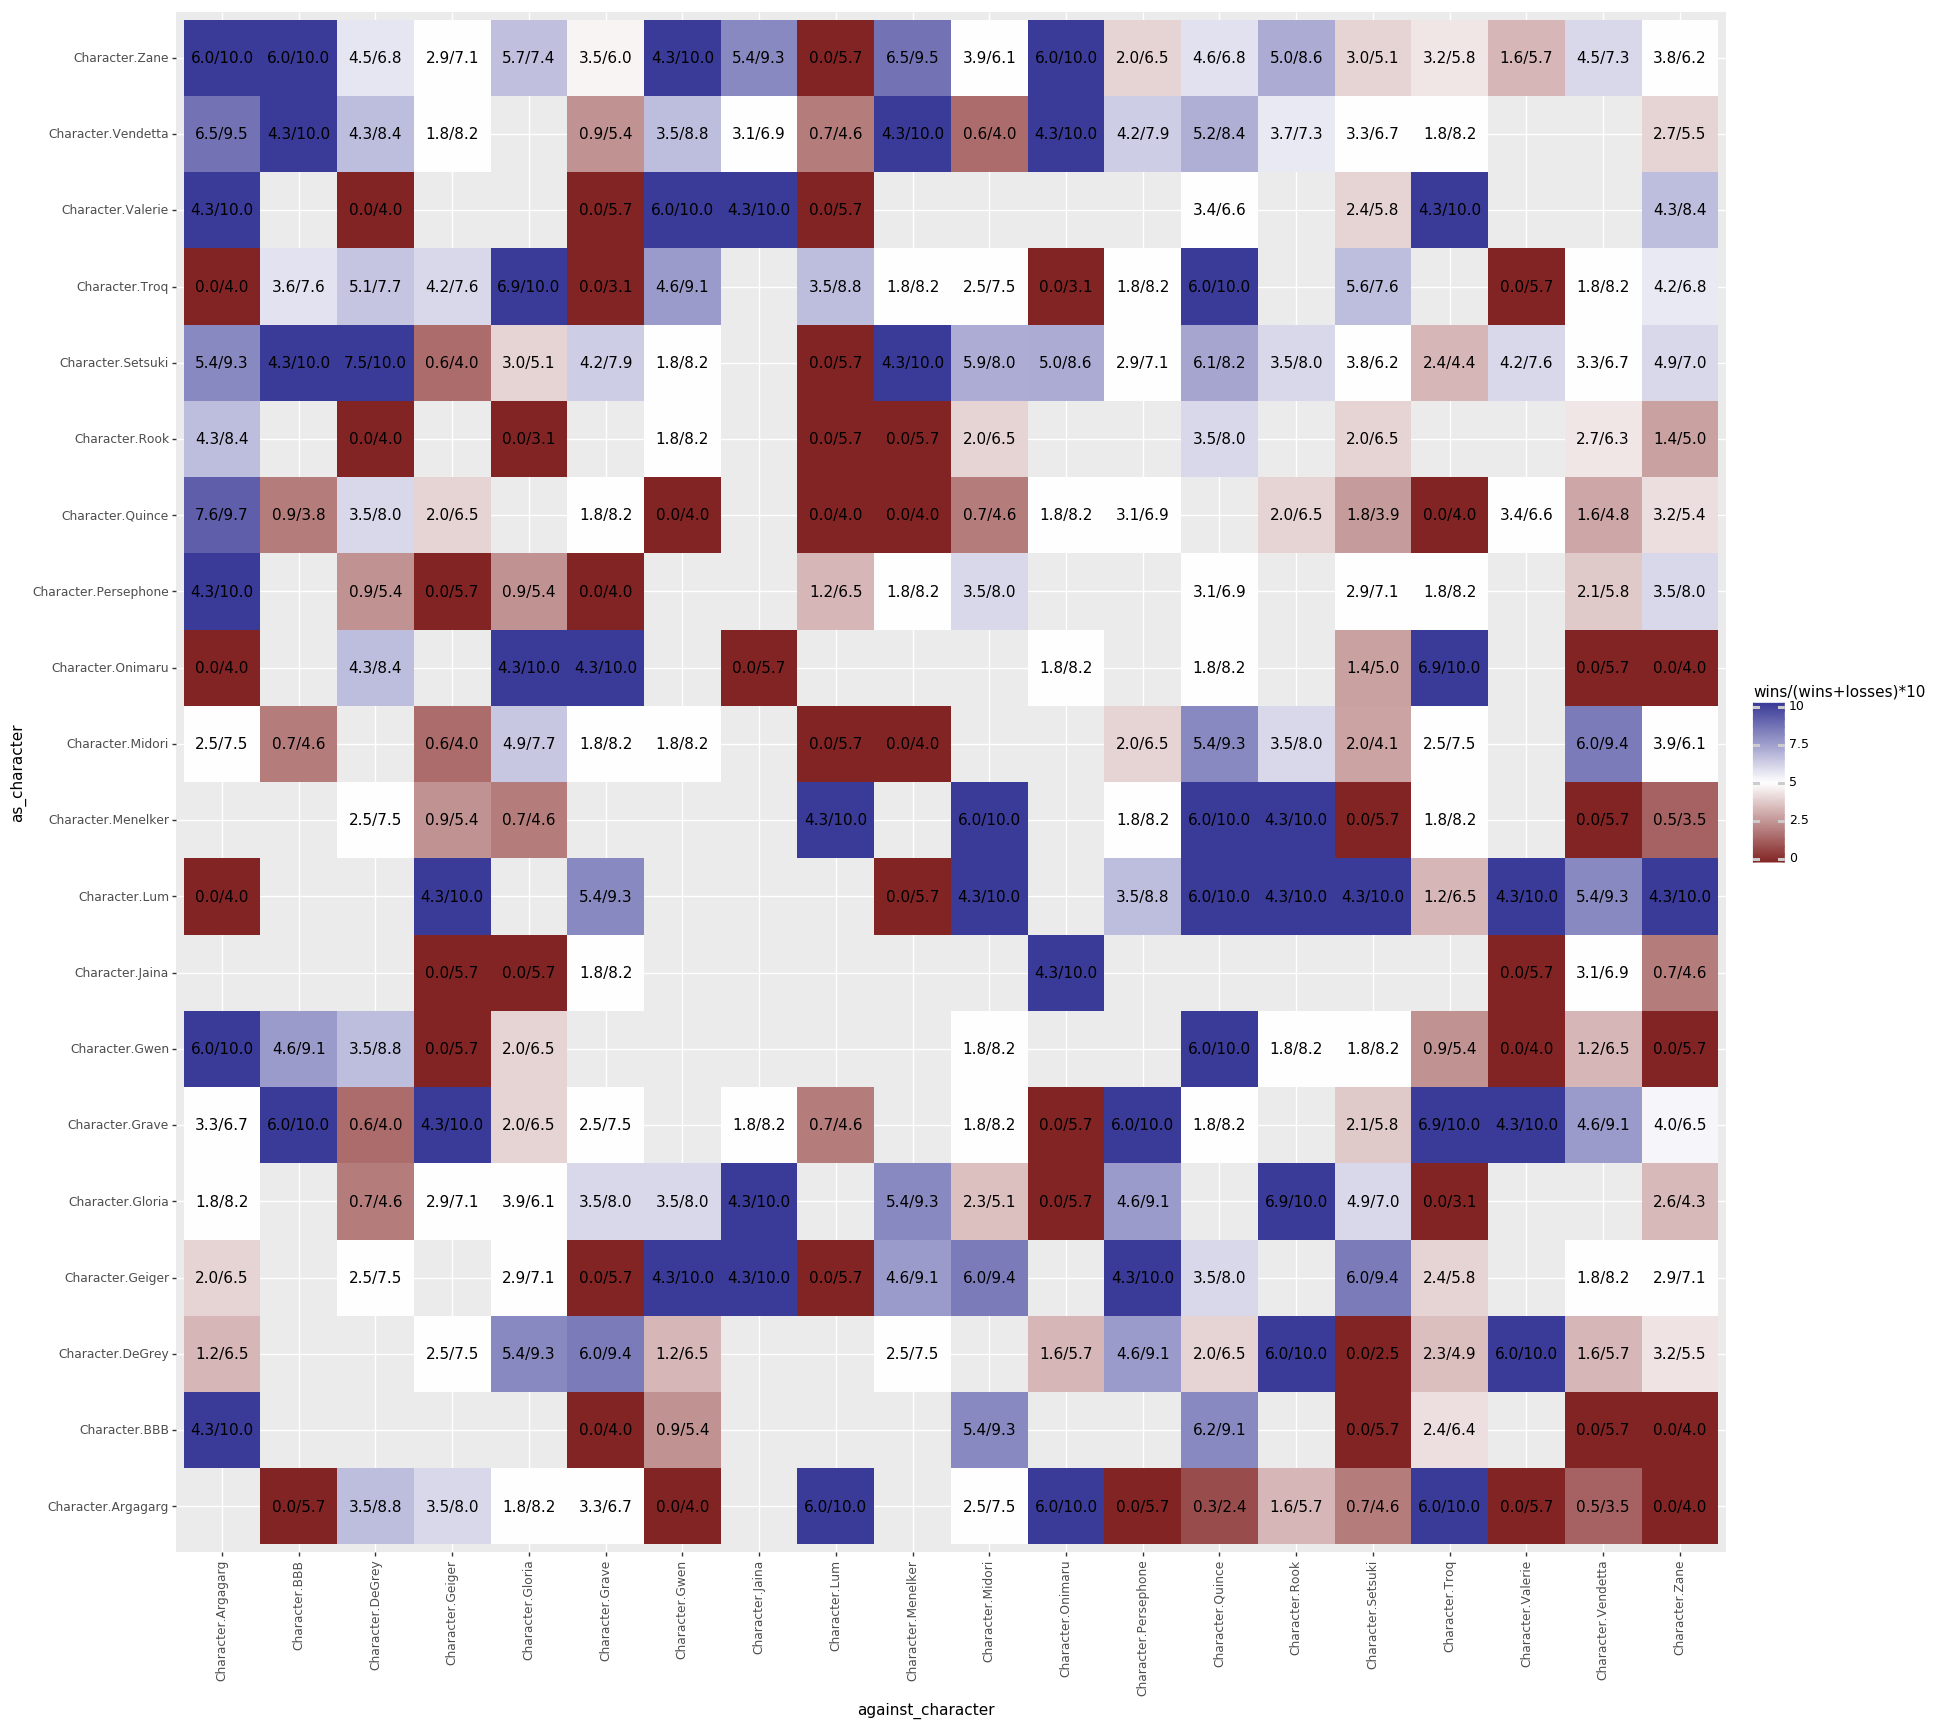

<ggplot: (-9223363252745651943)>

In [492]:
from plotnine import *

(
    ggplot(expert_mu_pcts.reset_index(), aes(y='as_character', x='against_character', fill='wins/(wins+losses)*10'))
    + geom_tile(na_rm=True)
    + geom_text(aes(label='range'), na_rm=True)
    + theme(axis_text_x = element_text(angle = 90), figure_size=(20, 20))
    + scale_fill_gradient2(midpoint=5)
)